<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/hyperparam_experiments_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# name of subfolder under models/ where trained models should go
MODEL_PREFIX = "test2"

hyp_combos = [{'NUM_EPOCHS': 2,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [128, 64],
                'FILTER_SIZES': [3, 2],
                'DROPOUT_RATES': [.2, .2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50},
              
                {'NUM_EPOCHS': 3,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 10,
                'NUM_LAYERS': 3,
                'CONV_LAYER_SIZES': [128, 64, 32],
                'FILTER_SIZES': [3, 2, 3],
                'DROPOUT_RATES': [.2, .2, .2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50}
                ]

In [0]:
## check to ensure hyps are in agreement
for hyp_combo in hyp_combos:
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['CONV_LAYER_SIZES'])
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['FILTER_SIZES'])
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['DROPOUT_RATES'])

In [8]:
## all this stuff just needs to get run one time per notebook
# Set seeds for reproducible results.
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from keras.preprocessing.sequence import pad_sequences
from scipy.sparse import hstack, vstack
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential, layers
from keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}


Updated property [core/project].


In [9]:
train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
!gsutil cp gs://fb-congressional-data/glove* /tmp/

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Copying gs://fb-congressional-data/glove.6B.100d.txt...
Copying gs://fb-congressional-data/glove.6B.200d.txt...
Copying gs://fb-congressional-data/glove.6B.300d.txt...
Copying gs://fb-congressional-data/glove.6B.50d.txt...
\ [4 files][  2.1 GiB/  2.1 GiB]   66.6 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fb-congressional-data/glove.6B.zip...
- [5 files][  2.9 GiB/  2.9 GiB]   22.3 MiB/s                                   
Operation completed over 5 objects/2.9 GiB.                                      


In [0]:
# all the functions go here
def remove_excess_rows_per_post(df, max_per_post):
  num_responses_per_post = df.post_id.value_counts().reset_index()
  num_responses_per_post.columns = ['post_id', 'num_responses']
  
  too_big_posts = num_responses_per_post[num_responses_per_post.num_responses > max_per_post]
  posts_to_sample = too_big_posts.post_id.values
  
  # this gets all the rows for posts we DON'T need to sample 
  new_train_df = df[~df.post_id.isin(posts_to_sample)]
  # this should be true
  assert(len(too_big_posts) + new_train_df.post_id.nunique() == df.post_id.nunique())
  
  too_big_post_rows = df[df.post_id.isin(posts_to_sample)]
  sampled_rows = too_big_post_rows.groupby('post_id').apply(lambda x: x.sample(n=max_per_post)).reset_index(drop=True)
  new_train_df = pd.concat([new_train_df, sampled_rows])
  
  return new_train_df

def get_labels(train_df, test_df, party_label_ind):

  def turn_to_ints(li):
    final_list = []
    for gender in li:
        if gender=='M':
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

  def turn_to_ints_party(li):
    final_list = []
    for party in li:
        if party=='Congress_Republican':
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

  if party_label_ind:
    train_df = train_df[train_df.op_category!='Congress_Independent']

    y_train = train_df.op_category.values
    y_dev = test_df.op_category.values
    y_train = turn_to_ints_party(y_train)
    y_dev = turn_to_ints_party(y_dev) 

  else:
    y_train = train_df.op_gender.values
    y_dev = test_df.op_gender.values
    y_train = turn_to_ints(y_train)
    y_dev = turn_to_ints(y_dev)

  y_train = np.asarray(y_train)
  y_dev = np.asarray(y_dev)

  return y_train, y_dev

def get_inputs(train_df, 
               test_df, 
               n_words_to_keep,
               max_seq_length):
  def get_text_list(init_list):
      sentences = []
      for sentence in init_list:
          if type(sentence) != str:
              sentences.append("")
          else:
              sentences.append(sentence)
      return sentences

  new_sentences_train = get_text_list(new_train_df.response_text.values)
  new_sentences_test = get_text_list(dev_df.response_text.values)

  time_start = time.time()

  # this is the default list of filters + apostrophe
  # added because we have dealt with common contractions, so other apostrophes should mostly be possessive 
  tokenizer = Tokenizer(filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='UNK')
  tokenizer.fit_on_texts(new_sentences_train)


  currentTime = time.gmtime(time.time() - time_start)

  #Convert the gmtime struct to a string
  timeStr = time.strftime("%M minutes, %S seconds", currentTime)

  print("Tokenized in {}".format(timeStr))

  # suggestion from this issue: https://github.com/keras-team/keras/issues/8092
  # seems like OOV and num_words don't work correctly by default 
  tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() 
                              if i <= n_words_to_keep + 1} 
  tokenizer.word_index[tokenizer.oov_token] = n_words_to_keep + 1

  X_train = tokenizer.texts_to_sequences(new_sentences_train)
  X_test = tokenizer.texts_to_sequences(new_sentences_test)

  X_train = pad_sequences(X_train, padding='post', maxlen=max_seq_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_seq_length)
  return X_train, X_test, tokenizer

def create_embedding_matrix(filepath, 
                            word_index, 
                            embedding_dim):
    vocab_size = len(word_index) + 2  # Now we have to add 2 (reserved 0 plus the manual UNK token)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def make_model(embedding_matrix, 
               max_seq_length,
               num_layers,
               conv_layer_size,
               filter_size,
               dropout_rate,
               final_hidden_dense_size):
  model = Sequential()

  try:
    model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                              weights=[embedding_matrix], 
                              input_length=max_seq_length, 
                              trainable=False))
    for i in range(num_layers):
      model.add(layers.Conv1D(conv_layer_size[i], filter_size[i], activation='relu', padding="same"))
      model.add(layers.Dropout(dropout_rate[i]))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(final_hidden_dense_size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  except Exception as ex:
    print(ex)
  finally:
    return model

def train_model(model, 
                train_labels,
                dev_labels,
                num_epochs,
                batch_size):
  try:
    time_start = time.time()

    history = model.fit(X_train, train_labels,
                        epochs=num_epochs,
                        verbose=True,
                        validation_data=(X_test, dev_labels),
                        batch_size=batch_size)

    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))

  except Exception as ex:
    print("Exception: {}".format(ex))
    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))  
  finally:
    return model

def pred_to_label(row):
  if row['probs'] >= .5:
    return 'M'
  else:
    return 'W'

Training Model 0
Limiting by responses per post resulted in 3962284 training rows
Getting labels
Getting inputs
Tokenized in 00 minutes, 00 seconds
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 50)            250150    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 20, 128)           19328     
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 20, 64)            16448     
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64

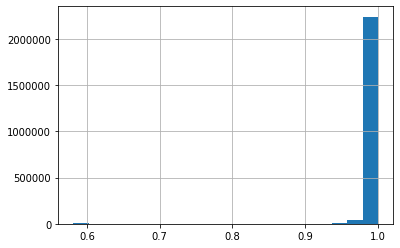

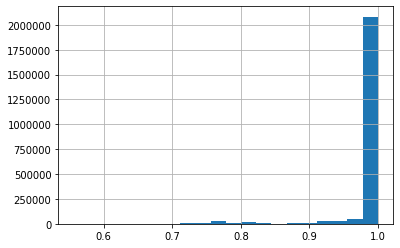

In [11]:
for i, hyp_dict in enumerate(hyp_combos):
  print("Training Model {}".format(i))
  new_train_df = remove_excess_rows_per_post(train_df, hyp_dict['MAX_RESPONSES_PER_POST'])
  print("Limiting by responses per post resulted in {} training rows".format(new_train_df.shape[0]))

  # TODO: remove this line after testing
  new_train_df = new_train_df[:10000]

  new_train_df = new_train_df.sample(frac=1)
  dev_df = dev_df.sample(frac=1)

  # get two sets of labels: gender and party
  print("Getting labels")
  y_train_gender, y_dev_gender = get_labels(new_train_df, dev_df, False)
  y_train_party, y_dev_party = get_labels(new_train_df, dev_df, True)

  print("Getting inputs")
  X_train, X_test, tokenizer = get_inputs(new_train_df, 
                                          dev_df, 
                                          hyp_dict['N_MOST_FREQ_WORDS_TO_KEEP'], 
                                          hyp_dict['MAX_SEQUENCE_LENGTH'])
  embedding_matrix = create_embedding_matrix(
                     '/tmp/glove.6B.{}d.txt'.format(hyp_dict['EMBEDDING_DIM']),
                      tokenizer.word_index, hyp_dict['EMBEDDING_DIM'])
  
  # gender model
  model = make_model(embedding_matrix, 
                     hyp_dict['MAX_SEQUENCE_LENGTH'],
                     hyp_dict['NUM_LAYERS'],
                     hyp_dict['CONV_LAYER_SIZES'],
                     hyp_dict['FILTER_SIZES'],
                     hyp_dict['DROPOUT_RATES'],
                     hyp_dict['FINAL_DENSE_LAYER_SIZE'])
  print(model.summary())
  trained_model = train_model(model,
                              y_train_gender,
                              y_dev_gender,
                              hyp_dict['NUM_EPOCHS'],
                              hyp_dict['BATCH_SIZE']
                              )
  
  # adding epoch time just in case we accidentally re-use the same prefixes 
  gender_model_path = '{}_model_{}_gender_{}.h5'.format(MODEL_PREFIX, i, time.time())
  model.save(gender_model_path)
  !gsutil cp /content/{gender_model_path} gs://fb-congressional-data/models/{gender_model_path}

  preds = model.predict(X_test)
  dev_df['probs'] = preds
  dev_df['preds'] = dev_df.apply(pred_to_label, axis=1)

  if 'W' in dev_df.preds.value_counts():
    proportion_women_predicted = dev_df.preds.value_counts()['W'] / len(dev_df)
  else:
    proportion_women_predicted = 0
  print("Proportion of predictions for W class: {}".format(proportion_women_predicted))
  plt.figure()
  print(dev_df.probs.hist(bins=20))

  # party model
  model2 = make_model(embedding_matrix, 
                      hyp_dict['MAX_SEQUENCE_LENGTH'],
                      hyp_dict['NUM_LAYERS'],
                      hyp_dict['CONV_LAYER_SIZES'],
                      hyp_dict['FILTER_SIZES'],
                      hyp_dict['DROPOUT_RATES'],
                      hyp_dict['FINAL_DENSE_LAYER_SIZE'])
  trained_model2 = train_model(model2,
                               y_train_party,
                               y_dev_party,
                               hyp_dict['NUM_EPOCHS'],
                               hyp_dict['BATCH_SIZE'])
  
  party_model_path = '{}_model_{}_party.h5'.format(MODEL_PREFIX, i)
  model.save(party_model_path)
  !gsutil cp /content/{party_model_path} gs://fb-congressional-data/models/{party_model_path}
 
  
  
    